# Bert Regressor

In [1]:
import tensorflow as tf
import modeling
import tokenization
import optimization
import run_regressor
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


## Preprocessing for Data
give indice to reviewerID, asin

In [2]:
train_df = pd.read_csv('/home/ubuntu/glue_data/ARD/train.tsv','\t')
dev_df = pd.read_csv('/home/ubuntu/glue_data/ARD/dev.tsv','\t')
test_df = pd.read_csv('/home/ubuntu/glue_data/ARD/test.tsv','\t')
all_df = train_df.append(dev_df).append(test_df)

In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.hstack((all_df.asin,all_df.reviewerID)))
def add_indice_cols(df):
    df_ = df.copy()
    df_['user_id'] = label_encoder.transform(df_['reviewerID'])
    df_['item_id'] = label_encoder.transform(df_['asin'])
    return df_

In [4]:
train_df = add_indice_cols(train_df)
dev_df = add_indice_cols(dev_df)
test_df = add_indice_cols(test_df)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_df, dev_df = train_test_split(train_df.append(dev_df), test_size=0.33, shuffle=True)

In [7]:
train_df.to_csv('/home/ubuntu/glue_data/ARD/train.tsv',sep='\t',index=None)
dev_df.to_csv('/home/ubuntu/glue_data/ARD/dev.tsv',sep='\t',index=None)
test_df.to_csv('/home/ubuntu/glue_data/ARD/test.tsv',sep='\t',index=None)

## Defining args

In [9]:
bert_config_file = '/home/ubuntu/bert_models/uncased_L-12_H-768_A-12/bert_config.json'
bert_config = modeling.BertConfig.from_json_file(bert_config_file)
vocab_file = '/home/ubuntu/bert_models/uncased_L-12_H-768_A-12/vocab.txt'
max_seq_length = 128
train_batch_size = 32
eval_batch_size = 32
predict_batch_size = 32
num_train_epochs=3.0
warmup_proportion = 0.1

''' tpu '''
save_checkpoints_steps = 1000
iterations_per_loop = 1000

DATA_DIR = '/home/ubuntu/glue_data/ARD/'
BERT_BASE_DIR = '/home/ubuntu/bert_models/uncased_L-12_H-768_A-12'
INIT_CHECKPOINT = '/home/ubuntu/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt'

## Defining methods

In [10]:
# using only textual information
def create_model(bert_config, is_training, input_ids, input_mask, segment_ids,values):
    """Creates a regression model."""
    model = modeling.BertModel(
      config=bert_config,
      is_training=is_training,
      input_ids=input_ids,
      input_mask=input_mask,
      token_type_ids=segment_ids)

    output_layer = model.get_pooled_output()

    hidden_size = output_layer.shape[-1].value

    output_weights = tf.get_variable(
      "output_weights", [1, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [1], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        if is_training:
          # I.e., 0.1 dropout
          output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        logits = tf.squeeze(logits)
        loss = tf.losses.mean_squared_error(values,logits)

    return (loss, logits)

レビュワー・商品のコンテクストを取り入れる

In [11]:
def get_distribution(df):
    user_cnt_dist = df.groupby(['user_id','overall'])['helpful_rate'].count().unstack(1,fill_value=0)
    item_cnt_dist = df.groupby(['item_id','overall'])['helpful_rate'].count().unstack(1,fill_value=0)
    all_cnt_dist = user_cnt_dist.append(item_cnt_dist).sort_index()
    all_dist = all_cnt_dist.apply(lambda x:x/sum(x),1)
    return all_dist

In [12]:
# using textual and user-item contextual information
def create_model2(bert_config, is_training, input_ids, input_mask, segment_ids,values,user_id,item_id,overall):
    """Creates a regression model."""
    # text information
    model = modeling.BertModel(
      config=bert_config,
      is_training=is_training,
      input_ids=input_ids,
      input_mask=input_mask,
      token_type_ids=segment_ids)

    output_layer = model.get_pooled_output()
    
    
    # User and Item and this rating information
    user_item_emb = tf.constant(get_distribution(all_df).values,dtype=tf.float32)
    user_dist = tf.nn.embedding_lookup(user_item_emb,user_id)
    item_dist = tf.nn.embedding_lookup(user_item_emb,item_id)
    rating_onehot = tf.one_hot(overall-1,depth=5,dtype=tf.float32)
    historical_ = tf.concat([user_dist,item_dist,rating_onehot],1)
    historical = tf.layers.dense(historical_,historical_.shape[-1].value)
    
    # concat
    bert_historical = tf.concat([output_layer,historical],1)
    
    hidden_size = bert_historical.shape[-1].value
    
    output_weights = tf.get_variable(
      "output_weights", [1, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [1], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        if is_training:
          # I.e., 0.1 dropout
          output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(bert_historical, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        logits = tf.squeeze(logits)
        loss = tf.losses.mean_squared_error(values,logits)

    return (loss, logits)

In [13]:
def model_fn_builder(bert_config, init_checkpoint, learning_rate,
                     num_train_steps, num_warmup_steps, use_tpu=False):
  """Returns `model_fn` closure"""

  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""
    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    values = features["values"]
    user_id = features["user_id"]
    item_id = features["item_id"]
    overall = features["overall"]

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    (total_loss, logits) = create_model2(
        bert_config, is_training, input_ids, input_mask, segment_ids, values,user_id,item_id,overall)
#     (total_loss, logits) = create_model(
#         bert_config, is_training, input_ids, input_mask, segment_ids, values)

    tvars = tf.trainable_variables()
    initialized_variable_names = {}
    scaffold_fn = None
    if init_checkpoint:
        (assignment_map, initialized_variable_names
              ) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
        if use_tpu:

            def tpu_scaffold():
                tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
                return tf.train.Scaffold()

            scaffold_fn = tpu_scaffold
        else:
            tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

    output_spec = None
    if mode == tf.estimator.ModeKeys.TRAIN:

        train_op = optimization.create_optimizer(total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)

        output_spec = tf.contrib.tpu.TPUEstimatorSpec(
                              mode=mode,
                              loss=total_loss,
                              train_op=train_op,
                              scaffold_fn=scaffold_fn)
    elif mode == tf.estimator.ModeKeys.EVAL:

        def metric_fn(total_loss, logits):
            return {
                "eval_loss": tf.metrics.mean_squared_error(labels=values,predictions=logits),
            }

        eval_metrics = (metric_fn, [total_loss, logits])
        output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          eval_metrics=eval_metrics,
          scaffold_fn=scaffold_fn)
    else:
        output_spec = tf.contrib.tpu.TPUEstimatorSpec(
            mode=mode, predictions=logits, scaffold_fn=scaffold_fn)
    return output_spec

  return model_fn


In [14]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
    """Creates an `input_fn` closure to be passed to TPUEstimator."""

    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    all_label_ids = []
    all_user_ids = []
    all_item_ids = []
    all_overalls = []

    for feature in features:
        all_input_ids.append(feature.input_ids)
        all_input_mask.append(feature.input_mask)
        all_segment_ids.append(feature.segment_ids)
        all_label_ids.append(feature.label_id)
        all_user_ids.append(feature.user_id)
        all_item_ids.append(feature.item_id)
        all_overalls.append(feature.overall)
  
    def input_fn(params):
        """The actual input function."""
        batch_size = params["batch_size"]

        num_examples = len(features)

        # This is for demo purposes and does NOT scale to large data sets. We do
        # not use Dataset.from_generator() because that uses tf.py_func which is
        # not TPU compatible. The right way to load data is with TFRecordReader.
        d = tf.data.Dataset.from_tensor_slices({
            "input_ids":
                tf.constant(
                    all_input_ids, shape=[num_examples, seq_length],
                    dtype=tf.int32),
            "input_mask":
                tf.constant(
                    all_input_mask,
                    shape=[num_examples, seq_length],
                    dtype=tf.int32),
            "segment_ids":
                tf.constant(
                    all_segment_ids,
                    shape=[num_examples, seq_length],
                    dtype=tf.int32),
            "values":
                tf.constant(all_label_ids, shape=[num_examples], dtype=tf.float32),
            "user_id":
                tf.constant(all_user_ids,shape=[num_examples],dtype=tf.int32),
            "item_id":
                tf.constant(all_item_ids,shape=[num_examples],dtype=tf.int32),
            "overall":
                tf.constant(all_overalls,shape=[num_examples],dtype=tf.int32),
        })

        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)

        d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
        return d

    return input_fn

## Construct Estimator

In [15]:
OUTPUT_DIR = '/home/ubuntu/tmp/bert_historical/'

In [16]:
processor = run_regressor.ArdProcessor()
tokenizer = tokenization.FullTokenizer(vocab_file=vocab_file,do_lower_case=True)

In [17]:
train_examples = processor.get_train_examples(DATA_DIR)
num_train_steps = int(len(train_examples) / train_batch_size * num_train_epochs)
num_warmup_steps = int(num_train_steps * warmup_proportion)

In [18]:
# tpu configuration
tpu_cluster_resolver = None
is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2
run_config = tf.contrib.tpu.RunConfig(
  cluster=tpu_cluster_resolver,
  master=None,
  model_dir=OUTPUT_DIR,
  save_checkpoints_steps=save_checkpoints_steps,
  tpu_config=tf.contrib.tpu.TPUConfig(
      iterations_per_loop=iterations_per_loop,
      num_shards=None,
      per_host_input_for_training=is_per_host))


In [19]:
model_fn = model_fn_builder(bert_config=bert_config,
                            init_checkpoint=INIT_CHECKPOINT,
                            learning_rate=2e-5,
                            num_train_steps=num_train_steps,
                            num_warmup_steps=num_warmup_steps)

In [20]:
estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=train_batch_size,
    eval_batch_size=eval_batch_size,
    predict_batch_size=predict_batch_size)

INFO:tensorflow:Using config: {'_model_dir': '/home/ubuntu/tmp/bert_historical/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fafad4f8240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=None, num_cores_per_replica=None, per_host_input_for_training=3, tpu_job_name=None, initial_infeed

## Training

In [ ]:
train_examples = processor.get_train_examples(DATA_DIR)

In [ ]:
train_features = run_regressor.convert_examples_to_features(train_examples,max_seq_length=max_seq_length,tokenizer=tokenizer)

In [ ]:
train_input_fn = input_fn_builder(train_features,max_seq_length,is_training=True,drop_remainder=True)

In [ ]:
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

## Evaluation

In [ ]:
eval_examples = processor.get_dev_examples(DATA_DIR)

In [ ]:
eval_features = run_regressor.convert_examples_to_features(eval_examples,max_seq_length=max_seq_length,tokenizer=tokenizer)

In [ ]:
# This tells the estimator to run through the entire set.
eval_steps = None

In [ ]:
eval_input_fn = input_fn_builder(eval_features,max_seq_length,is_training=False,drop_remainder=False)

In [ ]:
result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)

In [ ]:
result

## Prediction

In [21]:
predict_examples = processor.get_dev_examples(DATA_DIR)

In [22]:
predict_features = run_regressor.convert_examples_to_features(predict_examples,max_seq_length=max_seq_length,tokenizer=tokenizer)

INFO:tensorflow:Writing example 0 of 16500
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: dev-0
INFO:tensorflow:tokens: [CLS] i ' m a pc guy , i ' ve owned pc for 20 years and done professional support on them for over a decade and i ' ve never seen service as i ' ve seen with the mac ##book pro 15 " the machine itself is sleek and pretty , the display looks nice and it has a comfortable fit to it . the processor etc seems to do what needs to be done and does it well . it is however twice the price of a compatible pc . that in itself wouldn ' t be much of a problem . until there was a problem . my son wanted a mac , as his first machine , since he was paying for [SEP]
INFO:tensorflow:input_ids: 101 1045 1005 1049 1037 7473 3124 1010 1045 1005 2310 3079 7473 2005 2322 2086 1998 2589 2658 2490 2006 2068 2005 2058 1037 5476 1998 1045 1005 2310 2196 2464 2326 2004 1045 1005 2310 2464 2007 1996 6097 8654 4013 2321 1000 1996 3698 2993 2003 21185 1998 3492 1010 1996 4653 3504 3835 1998

In [23]:
predict_input_fn = input_fn_builder(predict_features,max_seq_length,is_training=False,drop_remainder=False)

In [24]:
result = estimator.predict(input_fn=predict_input_fn)

In [25]:
prediction = np.array(list(result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ubuntu/tmp/bert_historical/model.ckpt-2343
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:prediction_loop marked as finished
INFO:tensorflow:prediction_loop marked as finished


In [26]:
labels = np.array([i.label for i in predict_examples])

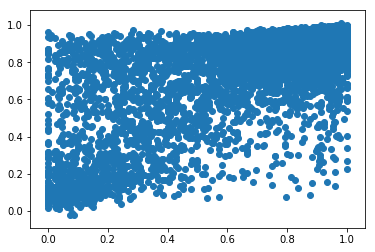

In [27]:
plt.scatter(labels,prediction)

In [28]:
from sklearn.metrics import mean_squared_error,r2_score

In [29]:
print(mean_squared_error(y_pred=prediction,y_true=labels))

print(r2_score(y_pred=prediction,y_true=labels))

0.022925790956573898
0.5529285620852855


(array([   85.,   298.,   213.,   179.,   214.,   250.,   399.,   867.,
         3939., 10056.]),
 array([-0.02315656,  0.08032277,  0.1838021 ,  0.28728143,  0.39076076,
         0.49424009,  0.59771942,  0.70119875,  0.80467808,  0.9081574 ,
         1.01163673]),
 <a list of 10 Patch objects>)

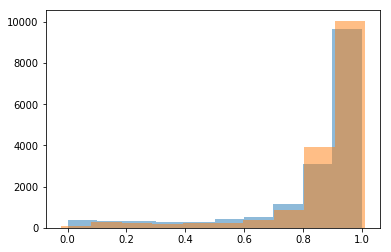

In [30]:
plt.hist(labels,alpha=0.5)
plt.hist(prediction,alpha=0.5)

In [ ]:
test_df = pd.read_csv('/home/ubuntu/glue_data/ARD/test.tsv',delimiter='\t')